# Final Project Report


## Introduction and Background

For the final project of DATA 512, I was interested in learning more about how to park in Seattle. More specifically, I wanted to know if actual parking data could illuminate ways that drivers can improve their parking experience by taking advantage of underutilized parking spots, favorable times of day, or any other interesting patterns when parking in the city. These same patterns hopefully could inform ways local government could better optimize their parking policies including spot allocation, payment, zones, and ticketing/enforcement. Since I both live and own a car in Seattle, I'm interested in these dynamics here in the city on a personal and practical level, but think it could be practically useful for others as well (including maybe those in other cities) due to the universal pain of city parking.

The City of Seattle sees the potential value in identifying parking trends as they've released paid parking studies annually since 2010 [1]. These studies have been made possible by data collected from smart parking meters deployed city-wide, and were motivated to better set parking price rates. Also in 2010, the Performance-Based Parking Pricing Program tied pricing to the performance goal of one to two spaces being open and available throughout the day [2]. The Seattle Department of Transportation has made over 250 changes to paid parking rates using these data over time, and proposed 32 more (17 rate increases, 14 rate decreases, 1 hour change) in their 2018 parking study. As one casn see, these policies can become quite complicated when time of day, season, and specific location are all considered (Fig 1).

A past DATA 512 student, Rex Thompson, looked at Seattle street parking data from 2012 to 2017 and found that drivers paid over 88 thousand dollars to park during peak hours when technically not allowed to do so, but that the city has since likely fixed this issue [3]. While this is intruiging and hints at other "bugs in the system" that are worth exploring, in this project I wanted to look more closely at location-specific city parking patterns within normal paid parking hours and policies. My overarching question is "How can I, as a Seattle driver, find parking today?", and I'll look at both location and time to answer those questions. 

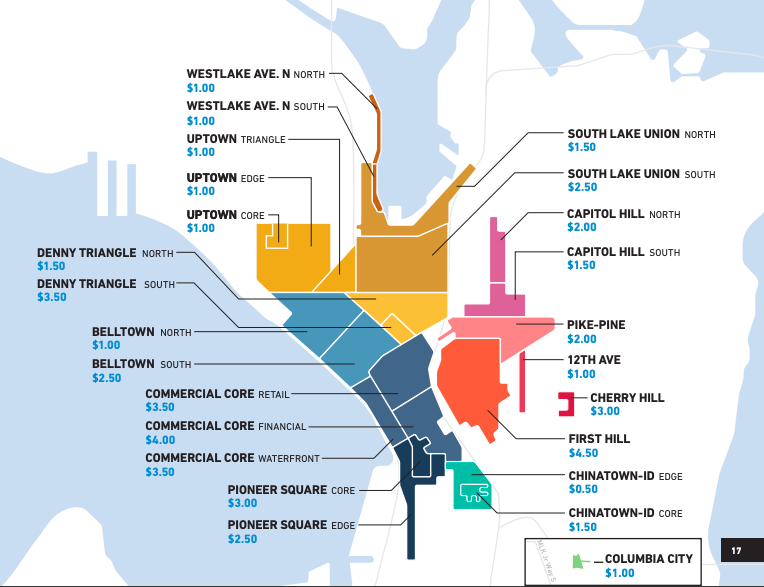
Figure 1 - Seattle Neighborhood Summer 2017 Rates [2]

## Data

The data set I'm using for this project is updated daily by the Seattle Department of Transportation and contains the last 30 days of paid parking occupancy in Seattle [4]. Government data, it's been released into the public domain, and contains no personally-identifiable information such as hashed or plaintext names, license numbers, car makes/models, etc. The provided license URL for all SDOT released data is at http://www.seattle.gov/transportation/projects-and-programs/programs/parking-program/maps-and-data. I downloaded the parking data on November 7th, and although updates come in daily, due to processing there is a 7 day delay for data to be uploaded to the site. Therefore the data I'll be working with starts on October 2nd 2019, ends on October 31st 2019, and contains 24.7 million individual paid parking instances. 

Each paid parking record has the following fields:

- OccupancyDateTime: Time parking transaction took place
- PaidOccupancy: Number of paid transactions on the blockface live at the time
- BlockfaceName: Street block being parked on
- SideOfStreet: Cardinal direction indicating which side of the block being parked on
- SourceElementKey: Unique ID for city street segment
- ParkingTimeLimitCategory: Time limit of parking in minutes
- ParkingSpaceCount: How many parking spaces the blockface holds
- PaidParkingArea: Defined parking area the block is in, effectively the neighborhood
- PaidParkingSubArea: Sub parking area the block is in, effectively subneighborhood
- PaidParkingRate: Deprecated
- ParkingCategory: Paid or Restricted Parking Zone
- Location: Lat-long of parking location

Probably the biggest limitation to this dataset is that it necessarily doesn't include unpaid parking whether done legally or illegally. Complicating this assumption is that there are many legal exceptions for paying (Sundays, disabled tags, etc.) as well as illegal ones (parked in a reserved bus lane during rush hour, food truck locations, etc.) However, by observing where people have paid and potentially comparing it with other public sources of data like neighborhood populations, I still hope to glean some interesting takeaways. The 30 day cap to the data also means I will miss out on any seasonal effects, but hopefully can still pick up on weekly trends. Ethically, I think my analysis and republication of these data is fairly benign with one exception: making it easier to park in the city could encourage people to choose driving over public transportation more often which could have negative environmental effects.

## Research Questions

Question 1. Which Seattle neighborhoods (and subneighborhoods) are the hardest and easiest in which to find paid parking spots?

Subquestion 1.1. Are there any specific blocks that act as useful outliers within these neighborhoods? 

Question 2. At which times of day and on which days of the week is it hardest and easiest to find paid parking spots, and how does this vary by neighborhood?

Subquestion 2.1. Are there any specific blocks that act as useful outliers within these times?


## Methodology

In this project, I didn't use any machine learning or serious statistics. My primary method was applying a calculation for parking occupancy, or number of occupied spots divided by total spots on a block, to various slices of the parking data. I'll often refer to this as just "occupancy" and that word already has usage by the city to refer to the same concept. Not only did this keep my analysis manageable, but this meant that interpretation of my results should be pretty straightforward as it doesn't require chewing on much math. The answers for "where/when should I park?" (at least what can be answered in this report) should be simple or else they wouldn't be very useful in practice.  

Assuming that we've established a definition for occupancy, I first calculate it for all blocks and then sort to find the most and least occupied blocks in all of Seattle. Then, I do the same for neighborhoods. Next, I filter using both pieces of information to find the emptiest blocks in the busiest neighborhoods.

After that, I consider the time dimension. I first calculate city-wide parking occupancy for all hours of the day by day of the week. Next, I look at the same for select neighborhoods and comment on some of the more interestng ones. Finally, although I mentioned research question 2.1 in this report, I chose not to pursue its analysis because I found that the sampled data were too thin to support meaningful analysis of individual blocks at specific hours in the week.

## Initial Data Sampling

In the below code I sample from the full 30 days of paid parking transactions. This is partially to make my analysis run faster and partially to make it so that all  analysis will be fully reproducible from files pulled from GitHub. If you're reproducing this analysis yourself from GitHub, you should skip this section and go straight to "Results" where the sampled data is read from an included file. 

In [124]:
# Import packages for dataframe manipulation and viewing all code output in-notebook.
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
# Load and preview full data (downloaded from the URL in Source #4)
parking_unsampled = pd.read_csv('Paid_Parking_Occupancy__Last_30_Days_.csv')
parking_unsampled.head()

OccupancyDateTime  PaidOccupancy  \
0  10/07/2019 10:27:00 AM              2   
1  10/07/2019 10:50:00 AM              1   
2  10/07/2019 11:25:00 AM              5   
3  10/07/2019 03:24:00 PM              4   
4  10/07/2019 11:31:00 AM              8   

                                       BlockfaceName SideOfStreet  \
0  EAST GREEN LAKE DR N BETWEEN NE 72ND ST AND NE...           NE   
1          2ND AVE BETWEEN VIRGINIA ST AND LENORA ST           SW   
2  UNIVERSITY WAY NE BETWEEN NE 47TH ST AND NE 50...            E   
3                4TH AVE BETWEEN WALL ST AND VINE ST           NE   
4        CLAY ST BETWEEN ELLIOTT AVE AND WESTERN AVE           SE   

   SourceElementKey  ParkingTimeLimitCategory  ParkingSpaceCount  \
0             59374                      30.0                  3   
1             70745                     120.0                  4   
2             35850                     120.0                 21   
3             28958                     240.0                  9   
4             77570                     240.0                 17   

       PaidParkingArea PaidParkingSubArea  PaidParkingRate ParkingCategory  \
0           Green Lake                NaN              NaN    Paid Parking   
1             Belltown              South              NaN    Paid Parking   
2  University District               Core              NaN    Paid Parking   
3             Belltown              North              NaN    Paid Parking   
4             Belltown              North              NaN    Paid Parking   

                            Location  
0  POINT (-122.32586409 47.68054512)  
1  POINT (-122.34247907 47.61204799)  
2   POINT (-122.3129946 47.66399698)  
3   POINT (-122.3465524 47.61701844)  
4  POINT (-122.35273225 47.61532287)

In [6]:
# Sample data. Starting file size is 3.73 GB so sampling by 1/40th to get under 100 MB for GitHub
import random
random.seed(0)
sample_frac = 0.025
parking_sampled = parking_unsampled.sample(frac = sample_frac)
parking_sampled.head()

OccupancyDateTime  PaidOccupancy  \
18045136  10/17/2019 11:19:00 AM              2   
8172041   10/08/2019 09:12:00 AM              1   
16054837  10/05/2019 05:54:00 PM              6   
8020669   10/08/2019 08:50:00 AM              7   
15258278  10/05/2019 09:23:00 AM              3   

                                              BlockfaceName SideOfStreet  \
18045136  BROADWAY E BETWEEN E HARRISON ST AND E REPUBLI...            W   
8172041           MARION ST BETWEEN BOREN AVE AND MINOR AVE           NW   
16054837      ALASKAN WAY BETWEEN VIRGINIA ST AND LENORA ST           SW   
8020669      NW 56TH ST BETWEEN 22ND AVE NW AND 24TH AVE NW            S   
15258278        HOWELL ST BETWEEN YALE AVE AND EASTLAKE AVE           NW   

          SourceElementKey  ParkingTimeLimitCategory  ParkingSpaceCount  \
18045136             32265                     120.0                  4   
8172041              11673                     120.0                  4   
16054837             76621                     120.0                 16   
8020669              86450                     240.0                 13   
15258278             33677                     240.0                  4   

         PaidParkingArea PaidParkingSubArea  PaidParkingRate ParkingCategory  \
18045136    Capitol Hill              North              NaN    Paid Parking   
8172041       First Hill                NaN              NaN    Paid Parking   
16054837        Belltown              South              NaN    Paid Parking   
8020669          Ballard               Edge              NaN    Paid Parking   
15258278  Denny Triangle              North              NaN    Paid Parking   

                                   Location  
18045136  POINT (-122.32102062 47.62255637)  
8172041   POINT (-122.32393114 47.60890535)  
16054837   POINT (-122.34572989 47.6095449)  
8020669   POINT (-122.38619958 47.66938747)  
15258278    POINT (-122.329559 47.61771697)

In [ ]:
# Write sampled data to file for GitHub
parking_sampled.to_csv('parking_sampled_init.csv')

## Results 1 - Busiest and Emptiest Blocks

To get us started, let's first find the most occupied and least occupied blocks in Seattle (with all sampling and reporting caveats). 

In [ ]:
# Optional - load parking_sampled if reproducing from GitHub
parking_sampled = pd.read_csv('parking_sampled_init.csv')

In [13]:
# Grab all individual blocks and initialize list that'll be used to calculate occupancy
blocknames = parking_sampled['BlockfaceName'].unique()
occupancy_by_block = []

In [20]:
# Iterate over all blocks
for i in range(len(blocknames)):
   
    # Calculate occupancy as occupied spots divided by number of total parking spaces
    parking_on_block = parking_sampled[parking_sampled['BlockfaceName'] == blocknames[i]]
    occupancy = parking_on_block['PaidOccupancy'].sum()/parking_on_block['ParkingSpaceCount'].sum()
    
    # Get neighborhood name
    neighborhood = parking_on_block.iloc[0,7]
    
    # Append (block name, neighborhood, occupancy) tuples to the list
    occupancy_by_block.append([blocknames[i],neighborhood,occupancy])                         

In [21]:
# Inspect results
occupancy_by_block[0:10]

[['BROADWAY E BETWEEN E HARRISON ST AND E REPUBLICAN ST',
  'Capitol Hill',
  0.7609703337453646],
 ['MARION ST BETWEEN BOREN AVE AND MINOR AVE',
  'First Hill',
  0.3135215453194651],
 ['ALASKAN WAY BETWEEN VIRGINIA ST AND LENORA ST',
  'Belltown',
  0.14478822469209973],
 ['NW 56TH ST BETWEEN 22ND AVE NW AND 24TH AVE NW',
  'Ballard',
  0.819424227721171],
 ['HOWELL ST BETWEEN YALE AVE AND EASTLAKE AVE',
  'Denny Triangle',
  0.3518835616438356],
 ['5TH AVE BETWEEN BATTERY ST AND WALL ST', 'Belltown', 0.5842358604091457],
 ['SENECA ST BETWEEN ALASKAN E RDWY WAY AND WESTERN AVE',
  'Commercial Core',
  0.19838229033631333],
 ['11TH AVE BETWEEN E OLIVE ST AND E HOWELL ST',
  'Capitol Hill',
  0.5885156856224365],
 ['E PIKE ST BETWEEN 12TH AVE AND 13TH AVE', 'Pike-Pine', 0.4796137339055794],
 ['SENECA ST BETWEEN BOREN AVE AND MINOR AVE',
  'First Hill',
  0.2096719648292188]]

In [22]:
# Create data frame from list and inspect again
col_names = ['block','neighborhood','occupancy']
occupancy_block_df = pd.DataFrame(occupancy_by_block,columns=col_names)
occupancy_block_df.head()

block    neighborhood  \
0  BROADWAY E BETWEEN E HARRISON ST AND E REPUBLI...    Capitol Hill   
1          MARION ST BETWEEN BOREN AVE AND MINOR AVE      First Hill   
2      ALASKAN WAY BETWEEN VIRGINIA ST AND LENORA ST        Belltown   
3     NW 56TH ST BETWEEN 22ND AVE NW AND 24TH AVE NW         Ballard   
4        HOWELL ST BETWEEN YALE AVE AND EASTLAKE AVE  Denny Triangle   

   occupancy  
0   0.760970  
1   0.313522  
2   0.144788  
3   0.819424  
4   0.351884

In [23]:
# Busiest blocks are ones with greatest occupancy
busiest_blocks = occupancy_block_df.sort_values(by='occupancy', ascending=False)
busiest_blocks.head()

block      neighborhood  \
681      4TH AVE BETWEEN DILLING WAY AND JEFFERSON ST    Pioneer Square   
862        9TH AVE BETWEEN WESTLAKE AVE AND DENNY WAY    Denny Triangle   
789    E PINE ST BETWEEN BELLEVUE AVE AND CRAWFORD PL         Pike-Pine   
902  THOMAS ST BETWEEN BOREN AVE N AND FAIRVIEW AVE N  South Lake Union   
496       E UNION ST BETWEEN BROADWAY AND BROADWAY CT         Pike-Pine   

     occupancy  
681   1.395833  
862   1.312500  
789   1.296190  
902   1.221350  
496   1.189033

In [24]:
# Emptiest blocks are ones with lowest occupancy
emptiest_blocks = occupancy_block_df.sort_values(by='occupancy', ascending=True)
emptiest_blocks.head()

block      neighborhood  \
904               BELL ST BETWEEN 7TH AVE AND 8TH AVE    Denny Triangle   
907            ALDER ST BETWEEN 9TH AVE AND TERRY AVE        First Hill   
903         BOREN AVE N BETWEEN DENNY WAY AND JOHN ST  South Lake Union   
905         8TH AVE BETWEEN COLUMBIA ST AND MARION ST        First Hill   
716  NW 54TH SR ST BETWEEN 32ND AVE NW AND NW 54TH ST     Ballard Locks   

     occupancy  
904   0.014881  
907   0.018182  
903   0.018797  
905   0.023810  
716   0.024209

## Results 2 - Busiest and Emptiest Neighborhoods
Below I repeat the same analysis but for neighborhoods instead of blocks to get a sense of what parts of town are generally the easiest and hardest to park in. 

In [25]:
# Grab all individual neighborhoods and initialize list that'll be used to calculate occupancy
neighborhoods = parking_sampled['PaidParkingArea'].unique()
occupancy_by_neighborhood = []

In [26]:
# Iterate over neighborhoods
for i in range(len(neighborhoods)):
   
    # Calculate occupancy in the same way as before
    parking_in_neighborhood = parking_sampled[parking_sampled['PaidParkingArea'] == neighborhoods[i]]
    occupancy = parking_in_neighborhood['PaidOccupancy'].sum()/parking_in_neighborhood['ParkingSpaceCount'].sum()
    
    # Append (neighborhood, occupancy) tuples to the list
    occupancy_by_neighborhood.append([neighborhoods[i],occupancy])       

In [27]:
# Create data frame from list and inspect
col_names = ['neighborhood','occupancy']
occupancy_neighborhood_df = pd.DataFrame(occupancy_by_neighborhood,columns=col_names)
occupancy_neighborhood_df.head()

neighborhood  occupancy
0    Capitol Hill   0.484119
1      First Hill   0.157571
2        Belltown   0.468891
3         Ballard   0.645048
4  Denny Triangle   0.469461

In [28]:
# Busiest neighborhoods have highest occupancy
busiest_neighborhoods = occupancy_neighborhood_df.sort_values(by='occupancy', ascending=False)
busiest_neighborhoods.head()

neighborhood  occupancy
17  Uptown Triangle   0.781588
3           Ballard   0.645048
14       Green Lake   0.638886
15        Roosevelt   0.552270
16          Fremont   0.551598

In [30]:
# Emptiest neighborhoods have lowest occupancy
emptiest_neighborhoods = occupancy_neighborhood_df.sort_values(by='occupancy', ascending=True)
emptiest_neighborhoods.head()

neighborhood  occupancy
1         First Hill   0.157571
20       Cherry Hill   0.162085
19     Ballard Locks   0.268879
8   South Lake Union   0.322170
13    Pioneer Square   0.385354

## Results 3 - Empty blocks in busy neighborhoods
At this step in my results I try to find something a bit more useful: the best place to park in the busiest neighborhoods. 

In [31]:
# We already have all blocks sorted by emptiest, now filter to the busiest neighborhood
empty_uptown_triangle = emptiest_blocks[emptiest_blocks['neighborhood'] == 'Uptown Triangle']
empty_uptown_triangle.head()

block     neighborhood  occupancy
628        5TH AVE N BETWEEN JOHN ST AND BROAD ST  Uptown Triangle   0.439167
270      4TH AVE N BETWEEN DENNY WAY AND BROAD ST  Uptown Triangle   0.581067
357       6TH AVE N BETWEEN DENNY WAY AND JOHN ST  Uptown Triangle   0.642696
441       6TH AVE N BETWEEN JOHN ST AND THOMAS ST  Uptown Triangle   0.718769
121  THOMAS ST BETWEEN TAYLOR AVE N AND 6TH AVE N  Uptown Triangle   0.744002

Below is a screenshot I took from Google Maps of the emptiest block in Uptown Triangle (Uptown Triangle:
5th Ave N between John St and Broad St) to show what it looked like. 

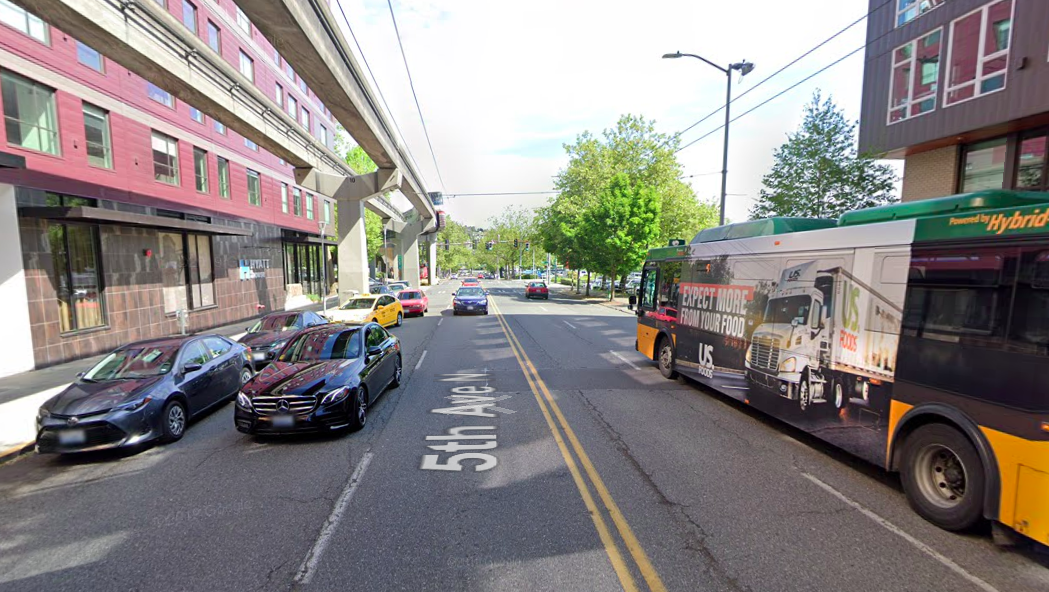
Image Capture: May 2019 © 2019 Google. Source Link: https://goo.gl/maps/8dmTF6vzSdjBrtGi9


Now we do the same for Ballard. The block is 24th Ave NW between NW Market St and NW 56th St. 

In [32]:
empty_ballard = emptiest_blocks[emptiest_blocks['neighborhood'] == 'Ballard']
empty_ballard.head()

block neighborhood  occupancy
636    24TH AVE NW BETWEEN NW MARKET ST AND NW 56TH ST      Ballard   0.214612
815   NW MARKET ST BETWEEN 15TH AVE NW AND 17TH AVE NW      Ballard   0.263747
774      24TH AVE NW BETWEEN NW 56TH ST AND NW 57TH ST      Ballard   0.408932
419  NW MARKET ST BETWEEN 20TH AVE NW AND RUSSELL A...      Ballard   0.422937
325  NW MARKET ST BETWEEN 17TH AVE NW AND BARNES AV...      Ballard   0.444085

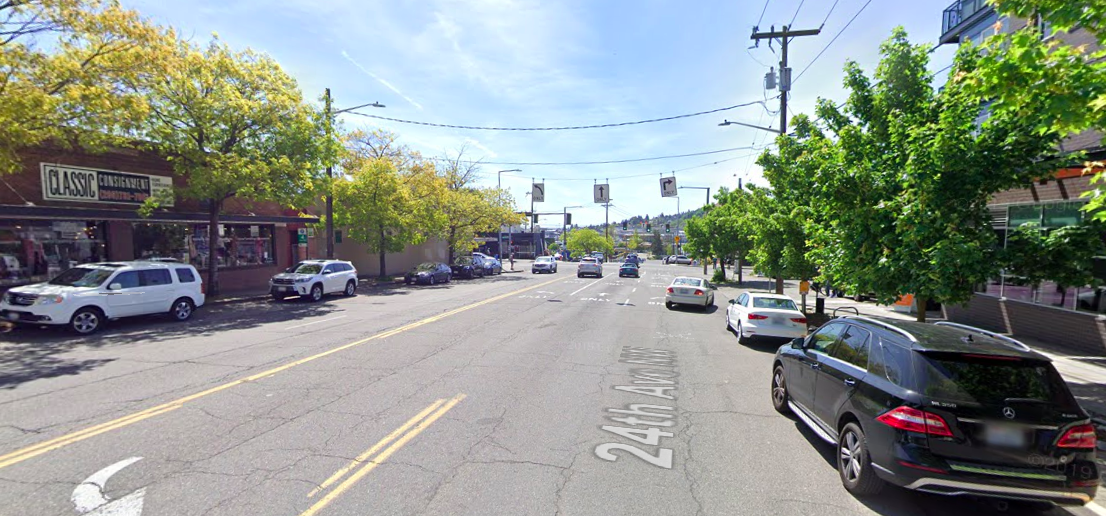
Image Capture: May 2019 © 2019 Google. Source Link: https://goo.gl/maps/maVdA4X6iXXCL8bh8

Finally, we do the same for Green Lake. The block is NE Ravenna Blvd (westbound) between NE 71st st and Woodlawn Ave NE.

In [33]:
empty_greenlake = emptiest_blocks[emptiest_blocks['neighborhood'] == 'Green Lake']
empty_greenlake.head()

block neighborhood  occupancy
302  NE RAVENNA WB BV BETWEEN NE 71ST ST AND WOODLA...   Green Lake   0.437500
658  NE 71ST ST BETWEEN EAST GREEN LAKE DR N AND WO...   Green Lake   0.512055
733  NE 70TH ST BETWEEN NE RAVENNA WB BV AND OSWEGO...   Green Lake   0.547282
842  EAST GREEN LAKE DR N BETWEEN NE 72ND ST AND NE...   Green Lake   0.579957
188  NE 71ST ST BETWEEN WOODLAWN AVE NE AND 5TH AVE NE   Green Lake   0.585550

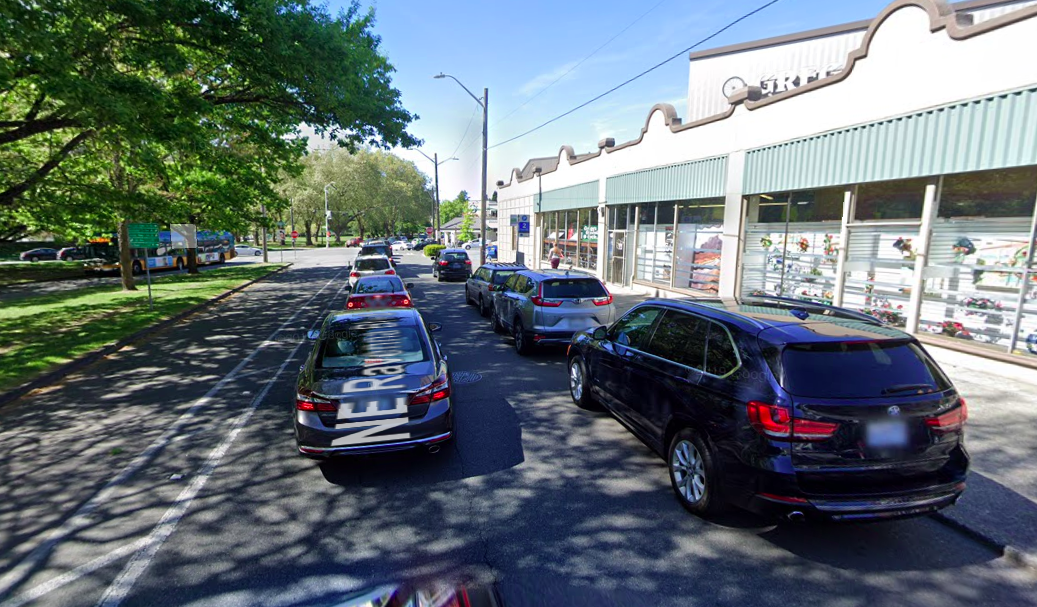
Image Capture: May 2019 © 2019 Google. Source Link: https://goo.gl/maps/9M9MtFc16KCmQSAY8

## Results 4 - Times of Day, City-wide
Here in my analysis I decide to look at the time dimension. My first goal is to look at overall city parking occupancy over the length of the day for each day of the week. 

In [60]:
# Parse hour of the day and day of the week from datetime strings
import datetime as dt
hours = []
weekdays = []

# Iterate over all parking occurrences
for i in range(parking_sampled.shape[0]):
    
    # Take advantage of how the datetime string is structured to pull out date, time, AM/PM
    dt_string = parking_sampled.iloc[i,0]
    date,time,half = dt_string.split()
    
    # Now extract month, day, year, hour, minute, and second from the substrings
    month,day,year = date.split('/')
    hour,minute,second = time.split(':')

    # Convert strings to integers for use in future functions
    year = int(year)
    month = int(month)
    day = int(day)
    hour = int(hour)

    # Make it so that the day goes from hour 0 (12AM - 1AM) to hour 23 (11 PM - 12 AM)
    # so that the day can be plotted on a single continuous line
    if hour == 12:
        hour = 0
    if half == 'PM':
        hour += 12
    
    # Make use of a built in datetime function to find the day of the week given the date
    weekday = dt.datetime(year, month, day).weekday()
    
    # Save hour of day and day of week to be added to dataframe later
    hours.append(hour)
    weekdays.append(weekday)


In [62]:
# Write data back into sampled parking data frame and sanity check
parking_sampled.insert(1, 'hour_of_day', hours)
parking_sampled.insert(2, "day_of_week", weekdays)
parking_sampled.head()

OccupancyDateTime  hour_of_day  day_of_week  PaidOccupancy  \
18045136  10/17/2019 11:19:00 AM           11            3              2   
8172041   10/08/2019 09:12:00 AM            9            1              1   
16054837  10/05/2019 05:54:00 PM           17            5              6   
8020669   10/08/2019 08:50:00 AM            8            1              7   
15258278  10/05/2019 09:23:00 AM            9            5              3   

                                              BlockfaceName SideOfStreet  \
18045136  BROADWAY E BETWEEN E HARRISON ST AND E REPUBLI...            W   
8172041           MARION ST BETWEEN BOREN AVE AND MINOR AVE           NW   
16054837      ALASKAN WAY BETWEEN VIRGINIA ST AND LENORA ST           SW   
8020669      NW 56TH ST BETWEEN 22ND AVE NW AND 24TH AVE NW            S   
15258278        HOWELL ST BETWEEN YALE AVE AND EASTLAKE AVE           NW   

          SourceElementKey  ParkingTimeLimitCategory  ParkingSpaceCount  \
18045136             32265                     120.0                  4   
8172041              11673                     120.0                  4   
16054837             76621                     120.0                 16   
8020669              86450                     240.0                 13   
15258278             33677                     240.0                  4   

         PaidParkingArea PaidParkingSubArea  PaidParkingRate ParkingCategory  \
18045136    Capitol Hill              North              NaN    Paid Parking   
8172041       First Hill                NaN              NaN    Paid Parking   
16054837        Belltown              South              NaN    Paid Parking   
8020669          Ballard               Edge              NaN    Paid Parking   
15258278  Denny Triangle              North              NaN    Paid Parking   

                                   Location  
18045136  POINT (-122.32102062 47.62255637)  
8172041   POINT (-122.32393114 47.60890535)  
16054837   POINT (-122.34572989 47.6095449)  
8020669   POINT (-122.38619958 47.66938747)  
15258278    POINT (-122.329559 47.61771697)

Now that we have hour of day and day of week for each paid parking instance, we can filter on hour of day and day of week then calculate occupancy in order to produce the figure we want. 

In [79]:
# Calculate occupancy values at each hour during the week for a set of parking transactions
def get_occupancy_by_hour(parking_sampled):
    # This will be the array that we dump overall occupancy at each hour during the week
    occupancy_by_hour = []

    # Iterate over all days except Sunday since there is no paid parking on Sunday (I confirmed it's not in the data)
    for day in range (6):

        # Filter to paid parking only for this day
        parking_on_day = parking_sampled[parking_sampled['day_of_week'] == day]

        # Iterate over all hours in the day
        for hour in range(24):

            # Filter to paid parking only for this hour
            parking_in_hour = parking_on_day[parking_on_day['hour_of_day'] == hour]

            # Any hour that doesn't have any paid parking should just have occupancy of zero
            if parking_in_hour.shape[0] == 0:
                occupancy_by_hour.append(0)

            # Otherwise calculate occupancy just like before
            else:
                occupancy = parking_in_hour['PaidOccupancy'].sum()/parking_in_hour['ParkingSpaceCount'].sum()
                occupancy_by_hour.append(occupancy)
                
    return occupancy_by_hour

In [99]:
occupancy_by_hour = get_occupancy_by_hour(parking_sampled)

At this step we have city-wide parking occupancy at each hour during the week. Next we can pull out each day's parking, assign it a color, and plot each day's occupancy on the same figure.  

In [93]:
import matplotlib.pyplot as plt

def plot_occupancy(occupancy_by_hour,s):  
    # Initialize the hours of day axis (0-23)
    hours_of_day = []
    for i in range(24):
        hours_of_day.append(i)

    # Plot every 24 hours' occupancy as a new day. Monday is day 0. The week progresses with colors of the rainbow. 
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.plot(hours_of_day, occupancy_by_hour[0:24], color='red', label='Monday')
    plt.plot(hours_of_day, occupancy_by_hour[24:48], color='orange', label='Tuesday')
    plt.plot(hours_of_day, occupancy_by_hour[48:72], color='yellow', label='Wednesday')
    plt.plot(hours_of_day, occupancy_by_hour[72:96], color='green', label='Thursday')
    plt.plot(hours_of_day, occupancy_by_hour[96:120], color='blue', label='Friday')
    plt.plot(hours_of_day, occupancy_by_hour[120:144], color='purple', label='Saturday')
    plt.xlabel('Hour of Day')
    plt.ylabel('Calculated Occupancy')
    plt.title('Hourly parking occupancy by day of the week: '+s)
    plt.legend()
    #plt.savefig('Final_Visualization.png')
    plt.show()

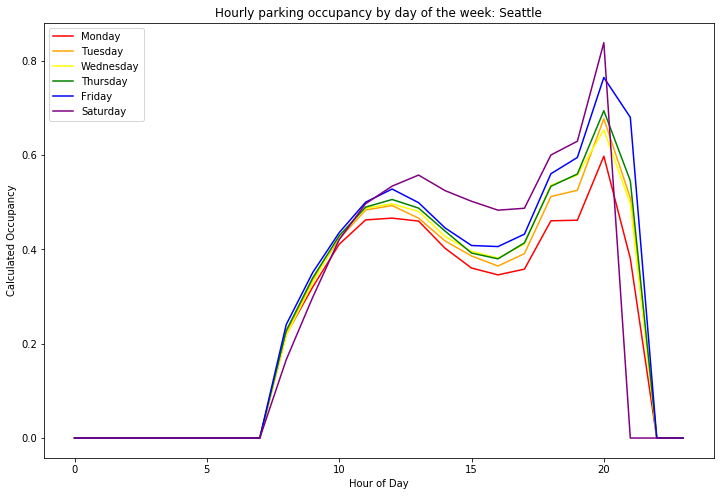

In [100]:
# Remove a crazy outlier for Saturday at 9:00 - 10:00 pm
occupancy_by_hour[141] = 0
plot_occupancy(occupancy_by_hour, 'Seattle')

In the above plot, we observe a couple things: 
- We can see that no paid parking occurs before 8 am or after 10 pm. Depending on the day, it can also end after the 8 pm hour.
- Parking occupancy seems to rise throughout the morning, hit a peak at around noon, and then dip throughout the mid afternoon before spiking again in the evening
- Parking occupancy steadily increases each day of the week
- There is a noticeable spike around 8:00 pm which I attribute to people parking for the night. Once you're in a spot, you can remain past the 2 hour window and leave your car until the morning without paying

## Results 5 - Times of Day, specific neighborhood

For my final results section, I reproduce the above to plot occupancy over the course of the day in a few different neighborhoods to see how the curves differ and then look to comment on interesting distinctions. 

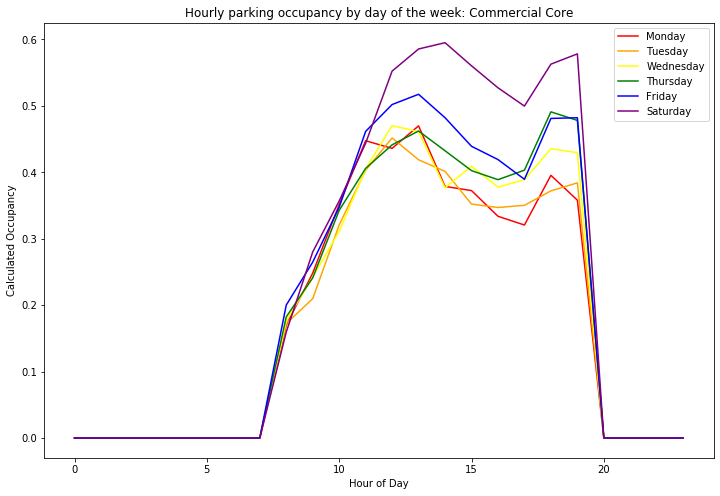

In [96]:
# Commercial Core
neighborhood_sampled = parking_sampled[parking_sampled['PaidParkingArea'] == 'Commercial Core']
occupancy_by_hour = get_occupancy_by_hour(neighborhood_sampled)
plot_occupancy(occupancy_by_hour, 'Commercial Core')

The commercial core (downtown) neighborhood looks similar to the overall Seattle occupancy plot. 
- There is a similar rise in parking until about noon at which point there is a slight lull
- The spike in the evening is less dramatic, likely because people don't leave their cars downtown as much overnight, often only spending time there during working hours

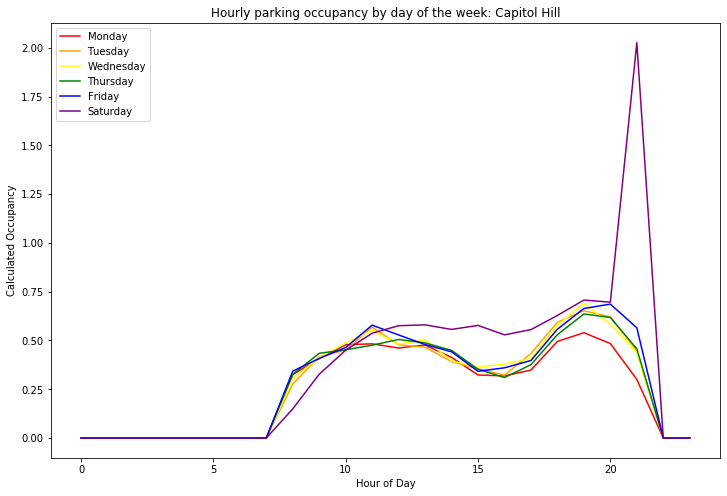

In [122]:
# Capitol Hill
neighborhood_sampled = parking_sampled[parking_sampled['PaidParkingArea'] == 'Capitol Hill']
occupancy_by_hour = get_occupancy_by_hour(neighborhood_sampled)
plot_occupancy(occupancy_by_hour, 'Capitol Hill')

The Capitol Hill neighborhood shows a similar plot to that of Seattle with two notable differences:
- There is no dip in parking during the afternoon on weekends, likely because it is a popular weekend destination
- The spike at the end of Saturday is extremely pronounced - my estimate is that Capitol Hill has a busy nightlife scene as well as residences and so many people will try and park over the weekend

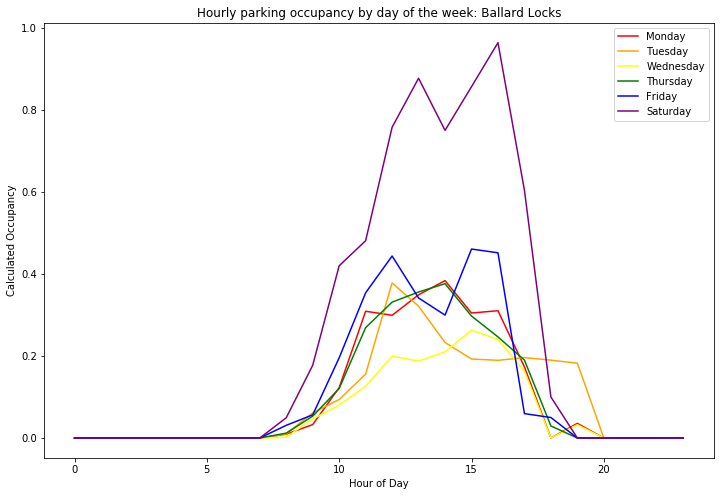

In [123]:
# Ballard Locks
uptown_triangle_sampled = parking_sampled[parking_sampled['PaidParkingArea'] == 'Ballard Locks']
occupancy_by_hour = get_occupancy_by_hour(uptown_triangle_sampled)
plot_occupancy(occupancy_by_hour, 'Ballard Locks')

The Ballard Locks neighborhood is a small region surrounding the Ballard Locks. All surrounding areas don't have paid parking, but as a tourist destination, the locks can often become busy, especially on weekends. In the above plot we see two notable things:
- There is no appreciable daily dip in parking in the early afternoon. I believe this is because people visit the Locks often on vacation and so aren't following a work schedule.
- Saturday's occupancy dwarfs that of the other days of the week. That also lines up with the area being a tourist destination that sees lots of weekend traffic. 

At this point, a natural next step which was referenced in Research Subquestion 2.1 would be to again find individual blocks that are exceptions to the rule in each neighborhood. However, after some reflection, I decided not to pursue this because there are simply so few hours (4-5) per block per week that can even possibly exist in the data. Given that I sampled the data heavily to begin with and that it only contains actual transactions (and not all parking), I didn't feel comfortable drawing conclusions from any results that were that granular. 

## Discussion

To sum up my results in a sentence: not all blocks are created equal and if you can swing it, you should find parking earlier in the day and earlier in the week. 

Unfortunately, all of my findings are subject to some pretty big caveats, some of which have already been mentioned. First, the data has been sampled from all parking transactions which themselves only span 30 days of the year. Next, the paid transactions only capture a subset of legal parking and an even smaller subset of all parking actually done in the city. Next and more subtly, I compute average occupancies over all parking instances rather than over regular time intervals so it's possible that some time intervals are missed entirely. I assume that most blocks over the course of a month will get enough regular parking that this usually won't matter too much, but consider that a completely empty block will be entirely missed by my analysis. 

Additionally, I ignored the unique ID (payment kiosk) and side of the street fields and instead used the blockface string as the most atomic identifier. Technically there is a difference between parking on a block going in one direction vs parking on it going in the other direction, so I could have gotten even more granular with my analysis. When you take one-way streets into consideration, this gets even more complicated though. It's important in any case, and a limitation of my results.  

Immediate extensions of this study would be to run it on a larger set of data (unsampled or multiple months of data). I could pursue a more granular definition of block to make even more specific parking recommendations. One idea that would be very cool though perhaps difficult to implement would be to pull in traffic information so as to minimize "Time to Park". An empty parking spot isn't all that helpful if it's so far off the beaten path that getting there doesn't actually save you any time. 

Other extensions I'd like to see might need help from other people. First off, I'd like to attempt to park in some of the recommended blocks multiple times to see how much the reported occupancy values vary from the real values. In theory, this could be used to adjust the illegal parking factor of the data. Lastly, I think that running any analysis in this vein would be useful for other cities in America as I'm sure each has its own unique traffic and parking patterns, though perhaps there are commonalities. 

One final point of pride is that apparently the full transaction data just started being gathered in 2018 and was just released for public use in 2019 (the annual report hasn't come out yet that I'm aware of) so this may be one of the only "studies" that's used it so far [1]. 

## Reflection

Answers to my research questions are as follows: 

Question 1: According to the data, by computed occupancy, the most crowded (hardest) neighborhoods to park in are Uptown Triangle, Ballard, and Greenlake, in order. The emptiest (easiest) are First Hill, Cherry Hill, and Ballard Locks. Specific blockfaces found as the biggest exceptions to the three busiest neighborhoods were 5th Ave N between John St and Broad St in Uptown Triangle, 24th Ave NW between NW Market St and NW 56th St in Ballard, and NE Ravenna Blvd (westbound) between NE 71st st and Woodlawn Ave NE in Greenlake. In general, finding these blocks may be tantamount to having a "favorite spot" that those in the know may be aware of already. 

Question 2: City-wide, earlier in the day is typically less busy than later in the day, though there is often a dip in the early afternoon, around 2-4 PM. Day of the week doesn't have a great impact on occupancy when considered city-wide, but in general parking gets a little harder later in the week. These patterns are fairly consistent for most Seattle neighborhoods though there are some exceptions that make intuitive sense (working areas have working time parking and tourist areas have tourist time parking). I abandoned subquestion 2.1 because it became apparent that focusing on a single block for a single hour during the week would return spotty results when analyzing heavily sampled data. This is unfortunate but I'm still interested in seeing answers to this question someday. 

One of my worries entering this assignment was that I'd be duplicating findings that the city will publish anyways in its 2019 annual report. Hopefully this was mitigated by three things:  making my analysis and code fully transparent and replicable, reporting on specific block outliers, and looking at day-of-the-week trends. Writing and executing the code was fairly straightforward though there were a couple pain points in doing the coding for this project. The first was around painful and slow read/writes from dataframes which I eventually mitigated by working with lists first before writing to dataframes. Another pain point was around fiddling with strings and the datetime functions. Hunting for the right functions to use and using them correctly was a bit tricky, but nothing too crazy.

Overall I'd hope that anyone could get a few takeaways from my analysis that apply to human life as it intersects with data science. First, even in cases when a city commits to data-driven decision making and releasing large amounts of data to the public like Seattle, drawing obvious conclusions with few caveats is extremely difficult.  The devil is always in the details. Second, although parking in the city is complicated and often painul, it can be made easier depending on time of day and block within a neighborhood. Although this may sound obvious, and though locals may already possess this in the form of tribal knowledge, hopefully by committing this study to the public I can render that a bit more rigorous. Third and finally, it's possible that the whole endeavor might be painful a bit by design. When city driving and parking is difficult, people are inherently more incentivized to pursue other options of transportation like public busses and trains. Perhaps that's the ultimate takeaway here: there is no silver bullet and paid parking is still paid, so maybe we should all try and take public transit. 


## Sources
1. https://data.seattle.gov/api/views/rke9-rsvs/files/4c21d126-ae8f-49f3-8ab9-9e0281542534?download=true&filename=Paid_Parking_Occupancy_Metadata.pdf
2. https://www.seattle.gov/Documents/Departments/SDOT/ParkingProgram/PaidParking/SDOT_AnnualReport2018.pdf
3. https://github.com/rexthompson/DATA-512-Final-Project/blob/master/DATA-512-Final-Project.ipynb
4. https://data.seattle.gov/Transportation/Paid-Parking-Occupancy-Last-30-Days-/rke9-rsvs